# Práctica 6 - DLT y RANSAC

In [50]:
import numpy as np
import math
import matplotlib.pyplot as plt
from imageio import imread
%matplotlib inline
from functools import reduce

# DLT

In [51]:
def printVars(results):
    for key in results.keys():
        print(key)
        print(results[key])
        print(" ")

In [52]:
def aplicarHsobrePunto(Hparam, x,y,z=1):
    punto = np.array([x,y,z])
    punto = Hparam @ punto # aplicamos H
    punto = punto/punto[2] # normalizamos
    return (int(punto[0]),int(punto[1]))

In [53]:
def aplicarH(H, img):
    imgTransformada = np.zeros(img.shape)

    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            punto = np.array([i,j,1])
            punto = H @ punto
            punto = punto/punto[2]
            puntoX = int(punto[0])
            puntoY = int(punto[1])

            
            if (puntoY < img.shape[0] and  puntoY>= 0) and (puntoX< img.shape[1] and puntoX>= 0):
                imgTransformada[j, i, :] = img[puntoY,puntoX,:].astype(np.uint8)


    return imgTransformada

Para obtener el H:
* Generar una matriz A, de dimensión 2n × 9, con las matrices Ai
* Descomponer A según SVD. A = UD(V^t)


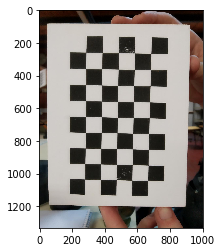

In [55]:
d1 = imread("img/dameros/damero1.png");
d2 = imread("img/dameros/damero2.png");

#d1 = imread("img/cuadrado1.png");
plt.imshow(d1);

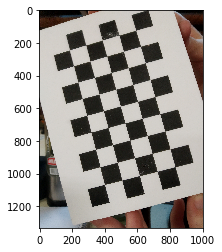

In [56]:
plt.imshow(d2);

In [57]:
#u,d,vt = np.linalg.svd(d1, full_matrices=True)
"Con esta descomposición tenemos que la última columna de la matriz V corresponde al vector de menor valor singular de la matriz A."
"O sea que la última fila de V corresponde al vector de menor valor singular de A"


'O sea que la última fila de V corresponde al vector de menor valor singular de A'

1. Tenemos mis correspondencias en el espacio pixel R2
2. Buscamos promedio y desvío estandard de ambos conjuntos de puntos de correspondencias.
3. Los normalizamos. O sea, les restamos el promedio y dividimos por sqrt(2)/desvio. Esto es equivalente a armar la H que transforma al espacio normal. Esta H es de 3x3, que escala y traslada.
H = [[s 0 -Mediax.s] [0 s -Mediay.s] [0 0 1]]
Obs: va a haber una H por conjunto de puntos. A la primera H la llamamos H norm, a la segunda H norm prima.
4. Pasamos todos los puntos a P2
5. Armamos las Ai, con eso armamos la A, y con eso obtenemos V. Con V obtenemos la H con puntito arriba, y con eso obtenemos la H final

### Dados 4 puntos de correspondencia:

Tenemos nuestras correspondencias en la primer imagen, y en la segunda

In [58]:
def invertirCoordenadas(conjuntoPuntos):
    return [(p[1],p[0]) for p in conjuntoPuntos]

In [59]:
#puntosDameroHD = [(867,779), (2055,800), (845,3110), (1997, 3137)]
#puntosOtroDameroHD = [(566,740),(1779,379), (1206, 3210), (2501, 2887)]

puntosDamero = [(289,259),(685,266),(282,1036),(665,1045)]
puntosOtroDamero = [(188,246),(593,126),(402,1069),(833,961)]

###### Redefinicion de puntos intercambiando coordenadas
puntosDamero = invertirCoordenadas(puntosDamero)
puntosOtroDamero = invertirCoordenadas(puntosOtroDamero)


In [60]:
puntos = puntosDamero
puntosX = [p[0] for p in puntos]
puntosY = [p[1] for p in puntos]

otrosPuntos = puntosOtroDamero
otrosPuntosX = [p[0] for p in otrosPuntos]
otrosPuntosY = [p[1] for p in otrosPuntos]

In [61]:
def marcar(pl, x, y):
    pl.plot(y,x,'bo', markersize=10)


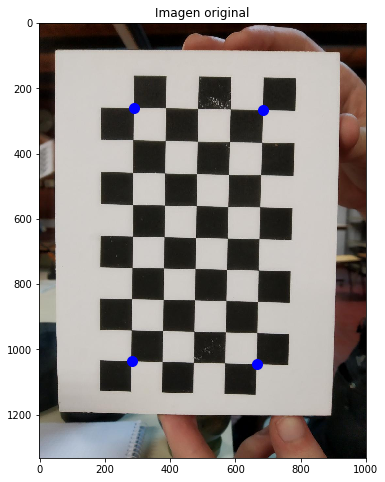

In [62]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen original")
plt.imshow(d1)

for elem in puntos:
    marcar(plt, elem[0], elem[1])

plt.show()

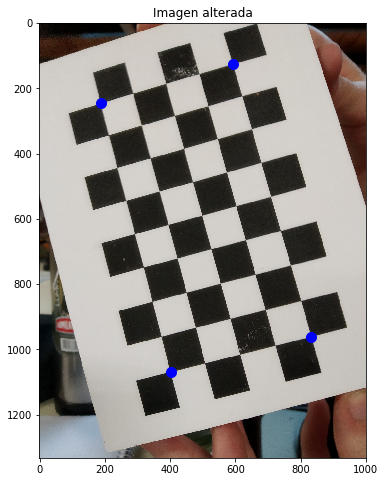

In [63]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen alterada")
plt.imshow(d2)

for elem in otrosPuntos:
    marcar(plt, elem[0], elem[1])

plt.show()

Buscamos el promedio y el desvío standard de ambos conjuntos de puntos de correspondencias

In [64]:
promedioPuntosX = np.mean(puntosX)
promedioPuntosY = np.mean(puntosY)

promedioOtrosPuntosX= np.mean(otrosPuntosX)
promedioOtrosPuntosY = np.mean(otrosPuntosY)

desvioPuntosX = np.std(puntosX)
desvioPuntosY = np.std(puntosY)

desvioOtrosPuntosX = np.std(otrosPuntosX)
desvioOtrosPuntosY = np.std(otrosPuntosY)

Los normalizamos. O sea, les restamos el promedio y multiplicamos por sqrt(2)/desvio. Esto es equivalente a armar la H que transforma al espacio normal. esta H es de 3x3, que escala y traslada. H = [[s 0 -Mediax.s] [0 s -Mediay.s] [0 0 1]] obs: va a haber una H por conjunto de puntos. A la primera H la llamamos H moño, a la segunda H moño prima.

In [65]:
puntosPromedio = np.mean(puntos, axis=0)
otrosPuntosPromedio = np.mean(otrosPuntos, axis=0)
puntosCentrados = puntos - np.tile(puntosPromedio, (len(puntos),1))
otrosPuntosCentrados = otrosPuntos - np.tile(otrosPuntosPromedio, (len(puntos),1))
normaPuntos = np.linalg.norm(puntosCentrados, axis=1)
normaOtrosPuntos = np.linalg.norm(otrosPuntosCentrados, axis=1)
dPuntos = np.mean(normaPuntos)
dOtrosPuntos = np.mean(normaPuntos)

sPuntos = np.sqrt(2)/dPuntos
sOtrosPuntos = np.sqrt(2)/dOtrosPuntos

Hnorm = np.array([[sPuntos,0      ,-np.mean(puntosX)*sPuntos],
                  [0      ,sPuntos,-np.mean(puntosY)*sPuntos],
                  [0      ,0      ,1]])

HnormPrima = np.array([[sOtrosPuntos,0      ,-np.mean(otrosPuntosX)*sOtrosPuntos],
                      [0      ,sOtrosPuntos,-np.mean(otrosPuntosY)*sOtrosPuntos],
                      [0      ,0      ,1]])


Pasamos los puntos a P2

In [66]:
puntosP2 = [(p[1],p[0],1)for p in zip(puntosX, puntosY)]
otrosPuntosP2 = [(p[1],p[0],1)for p in zip(otrosPuntosX, otrosPuntosY)]

print(puntosP2)

[(289, 259, 1), (685, 266, 1), (282, 1036, 1), (665, 1045, 1)]


Armamos las Ai, con eso armamos la A, y con eso obtenemos V. Con V obtenemos la H con puntito arriba, y con eso obtenemos la H final

In [67]:
def sumarMatriz(m1,m2): # a m1 le suma m2
    for i in range(len(m1)):
        for j in range(len(m1[0])):
            m1[i][j] = m1[i][j] + m2[i][j]        

In [68]:
def aplicarHsobrePuntoP2(H,p):
    vect = np.array([p[0],p[1],p[2]])
    res = H@vect
    x_pr = int(res[0])
    y_pr = int(res[1])
    z_pr = int(res[2])
    return(x_pr,y_pr,z_pr)

In [69]:
A = []

puntosP2Homologos = [Hnorm @ np.transpose(p) for p in puntosP2]
otrosPuntosP2Homologos = [(HnormPrima @ np.transpose(p)) for p in otrosPuntosP2]

printVars({"puntosP2Homologos": puntosP2Homologos,\
           "otrosPuntosP2Homologos": otrosPuntosP2Homologos})


for (x, xPrima) in zip(puntosP2Homologos, otrosPuntosP2Homologos):
    A.append([0,0,0,  -xPrima[2]*x[0], -xPrima[2]*x[1], -xPrima[2]*x[2],    xPrima[1]*x[0], xPrima[1]*x[1], xPrima[1]*x[2]])
    A.append([xPrima[2]*x[0], xPrima[2]*x[1], xPrima[2]*x[2],   0,0,0,  -xPrima[0]*x[0], -xPrima[0]*x[1], -xPrima[0]*x[2]])

otrosPuntosP2Homologos
[array([-1.34073418, -0.83856829,  1.        ]), array([-0.02437699, -1.22860005,  1.        ]), array([-0.64517754,  1.83639955,  1.        ]), array([0.75568654, 1.48537096, 1.        ])]
 
puntosP2Homologos
[array([-1.17822095, -0.71912106,  1.        ]), array([ 0.10888387, -0.69636921,  1.        ]), array([-1.2009728,  1.8063346,  1.       ]), array([0.04387857, 1.83558698, 1.        ])]
 


In [70]:
u,d,vt = np.linalg.svd(A)
"Con esta descomposición tenemos que la última columna de la matriz V corresponde al vector de menor valor singular de la matriz A. O sea que la última fila de V corresponde al vector de menor valor singular de A"

# chequeamos que SVD se haya hecho correctamente
sigma = np.diag(d)
sigma = np.transpose(np.vstack([sigma,[0,0,0,0,0,0,0,0]]))
deberiaSerA = np.matmul(np.matmul(u,sigma), vt)

for i in range(len(A)):
    for j in range(len(A[0])):
        if(abs(deberiaSerA[i][j] - A[i][j])>0.00001):
            print(str(deberiaSerA[i][j]) + " deberia ser " + str(A[i][j]))
            

"ultima columna de la matriz V = ultima fila de la matriz Vt"
fila = vt[-1]

Hpuntito = [[fila[0],fila[1],fila[2]],[fila[3],fila[4],fila[5]],[fila[6],fila[7],fila[8]]]

Hpuntito corresponde a la H con puntito arriba descripta en las diapositivas. Para obtener la H final debemos considerar la normalización que calculamos previamente

In [71]:
HnormPrimaInv = np.linalg.inv(HnormPrima)
Hfinal = np.dot(HnormPrimaInv, np.dot(Hpuntito, Hnorm))
Hfinal = Hfinal/Hfinal[2,2]


In [72]:
printVars({"Hfinal": Hfinal, "Hpuntito": Hpuntito, "Hnorm": Hnorm, "HnormPrima":HnormPrima})

HnormPrima
[[ 0.00325026  0.         -1.95178395]
 [ 0.          0.00325026 -1.6381334 ]
 [ 0.          0.          1.        ]]
 
Hnorm
[[ 0.00325026  0.         -2.11754745]
 [ 0.          0.00325026 -1.56093962]
 [ 0.          0.          1.        ]]
 
Hfinal
[[ 9.54414115e-01  2.33855066e-01 -1.55482280e+02]
 [-3.13146511e-01  9.10669541e-01  9.13610250e+01]
 [-4.14476827e-05 -9.93223477e-05  1.00000000e+00]]
 
Hpuntito
[[0.553674413244271, 0.16593672611837923, 0.04224027890226305], [-0.16523494985035608, 0.5431723081154616, -0.2603076386045249], [-0.0072097249234618355, -0.017276883996422437, 0.5231406343962355]]
 


In [77]:
dResultado = aplicarH(np.linalg.inv(Hfinal), d1)

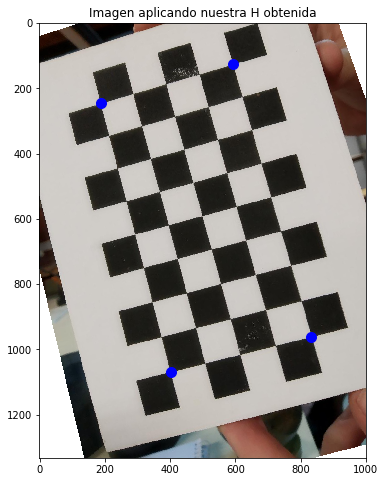

In [79]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen aplicando nuestra H obtenida")
plt.imshow(dResultado.astype(np.uint8));

for elem in otrosPuntos:
    marcar(plt, elem[0], elem[1])

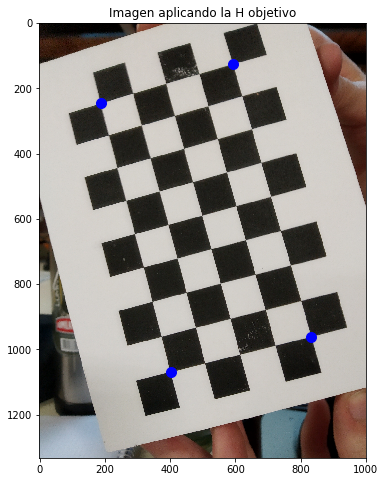

In [74]:
plt.figure(1, figsize=(8,8))
plt.plot()
plt.title("Imagen aplicando la H objetivo")
plt.imshow(d2);

for elem in otrosPuntos:
    marcar(plt, elem[0], elem[1])